# practice 3. 다중 선형 회귀, ridge, lasso

데이터 셋 링크: https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data

펭귄들의 종, 서식 지역, 부리 길이와 부리 깊이, 날개(?) 사이즈, 성별, 그리고 몸무게 데이터 셋이 있습니다. 다중 회귀 분석, 라쏘, 릿지 리그레션을 이용해서 몸무게를 예측하는 회귀 모델을 만들고, 어떤 독립변수가 가장 몸무게에 영향을 많이 미치는지 찾아보세요.

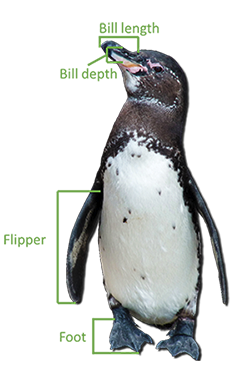

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from utils import load_penguin_dataset

x_train, x_test, y_train, y_test = load_penguin_dataset()

In [3]:
x_train

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,sex
225,Gentoo,Biscoe,46.5,13.5,210.0,FEMALE
119,Adelie,Torgersen,41.1,18.6,189.0,MALE
181,Chinstrap,Dream,52.8,20.0,205.0,MALE
167,Chinstrap,Dream,50.5,19.6,201.0,MALE
226,Gentoo,Biscoe,45.4,14.6,211.0,FEMALE
...,...,...,...,...,...,...
205,Chinstrap,Dream,50.7,19.7,203.0,MALE
54,Adelie,Biscoe,34.5,18.1,187.0,FEMALE
295,Gentoo,Biscoe,48.6,16.0,230.0,MALE
212,Chinstrap,Dream,51.9,19.5,206.0,MALE


In [4]:
x_train["weight"] = y_train

In [5]:
x_train

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,sex,weight
225,Gentoo,Biscoe,46.5,13.5,210.0,FEMALE,4550.0
119,Adelie,Torgersen,41.1,18.6,189.0,MALE,3325.0
181,Chinstrap,Dream,52.8,20.0,205.0,MALE,4550.0
167,Chinstrap,Dream,50.5,19.6,201.0,MALE,4050.0
226,Gentoo,Biscoe,45.4,14.6,211.0,FEMALE,4800.0
...,...,...,...,...,...,...,...
205,Chinstrap,Dream,50.7,19.7,203.0,MALE,4050.0
54,Adelie,Biscoe,34.5,18.1,187.0,FEMALE,2900.0
295,Gentoo,Biscoe,48.6,16.0,230.0,MALE,5800.0
212,Chinstrap,Dream,51.9,19.5,206.0,MALE,3950.0


결측치 확인

In [6]:
x_train.isnull().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
sex                  7
weight               0
dtype: int64

In [7]:
x_train["sex"].unique()

array(['FEMALE', 'MALE', '.', nan], dtype=object)

"sex"에 있는 '.' 값(1개) 제거

In [8]:
x_train = x_train[x_train["sex"]!='.']

In [9]:
x_train

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,sex,weight
225,Gentoo,Biscoe,46.5,13.5,210.0,FEMALE,4550.0
119,Adelie,Torgersen,41.1,18.6,189.0,MALE,3325.0
181,Chinstrap,Dream,52.8,20.0,205.0,MALE,4550.0
167,Chinstrap,Dream,50.5,19.6,201.0,MALE,4050.0
226,Gentoo,Biscoe,45.4,14.6,211.0,FEMALE,4800.0
...,...,...,...,...,...,...,...
205,Chinstrap,Dream,50.7,19.7,203.0,MALE,4050.0
54,Adelie,Biscoe,34.5,18.1,187.0,FEMALE,2900.0
295,Gentoo,Biscoe,48.6,16.0,230.0,MALE,5800.0
212,Chinstrap,Dream,51.9,19.5,206.0,MALE,3950.0


암/수 개체 수 비율 확인 -> 비슷하면 결측치 채워넣을 수 있을 듯?

In [10]:
x_train.groupby("sex")["species"].count()
# 결측치 5개 빼면 개수 맞음

sex
FEMALE    133
MALE      132
Name: species, dtype: int64

<Axes: xlabel='sex', ylabel='Count'>

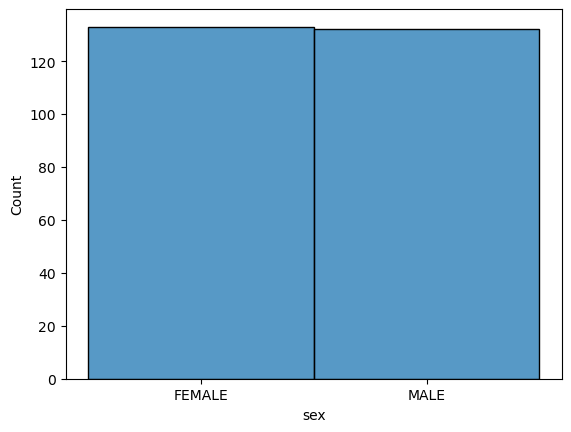

In [11]:
sns.histplot(
    data=x_train,
    x="sex"
)

비율 비슷하다! 몸무게 평균을 기준으로 높으면 MALE, 낮으면 FEMALE로 채워넣기!

In [12]:
x_train.groupby("sex")[["weight"]].mean()

,weight
sex,
FEMALE,3877.255639
MALE,4563.068182


In [13]:
(3877.256+4563.068)/2

4220.162

In [14]:
x_train[(x_train["sex"]=="FEMALE") & (x_train["weight"]<4220.162)]["weight"].count()

90

In [15]:
x_train[(x_train["sex"]=="MALE") & (x_train["weight"]>4220.162)]["weight"].count()

71

Text(0.5, 1.0, 'FEMALE weight distribution')

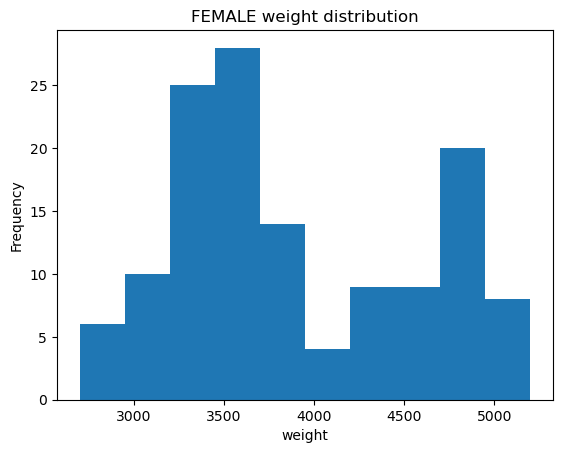

In [16]:
x_train[(x_train["sex"]=="FEMALE")]["weight"].plot(kind="hist")
plt.xlabel("weight")
plt.title("FEMALE weight distribution")

Text(0.5, 1.0, 'MALE weight distribution')

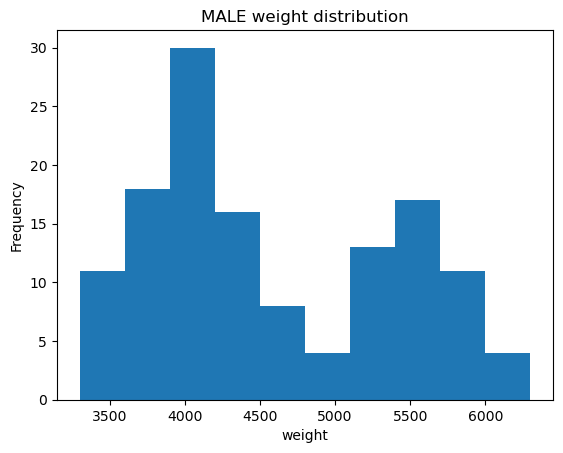

In [17]:
x_train[(x_train["sex"]=="MALE")]["weight"].plot(kind="hist")
plt.xlabel("weight")
plt.title("MALE weight distribution")

weight를 4220.162 기준으로 낮으면 FE, 높으면 M 적용

In [18]:
x_train_null = x_train[x_train["sex"].isnull()==True]

In [19]:
x_train_null

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,sex,weight
324,Gentoo,Biscoe,47.3,13.8,216.0,NaN,4725.0
10,Adelie,Torgersen,37.8,17.1,186.0,NaN,3300.0
9,Adelie,Torgersen,42.0,20.2,190.0,NaN,4250.0
47,Adelie,Dream,37.5,18.9,179.0,NaN,2975.0
286,Gentoo,Biscoe,46.2,14.4,214.0,NaN,4650.0
246,Gentoo,Biscoe,44.5,14.3,216.0,NaN,4100.0
11,Adelie,Torgersen,37.8,17.3,180.0,NaN,3700.0


In [20]:
weight_threshold = 4220.162

# "weight" 열의 값에 따라 "sex" 열에 레이블 할당
x_train_null['sex'] = x_train_null["weight"].apply(lambda x: 'MALE' if x > weight_threshold else 'FEMALE')

/var/folders/bc/bsqk8v9x20jgf1jsh_fbh7z40000gn/T/ipykernel_73737/3858793294.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train_null['sex'] = x_train_null["weight"].apply(lambda x: 'MALE' if x > weight_threshold else 'FEMALE')


In [21]:
x_train

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,sex,weight
225,Gentoo,Biscoe,46.5,13.5,210.0,FEMALE,4550.0
119,Adelie,Torgersen,41.1,18.6,189.0,MALE,3325.0
181,Chinstrap,Dream,52.8,20.0,205.0,MALE,4550.0
167,Chinstrap,Dream,50.5,19.6,201.0,MALE,4050.0
226,Gentoo,Biscoe,45.4,14.6,211.0,FEMALE,4800.0
...,...,...,...,...,...,...,...
205,Chinstrap,Dream,50.7,19.7,203.0,MALE,4050.0
54,Adelie,Biscoe,34.5,18.1,187.0,FEMALE,2900.0
295,Gentoo,Biscoe,48.6,16.0,230.0,MALE,5800.0
212,Chinstrap,Dream,51.9,19.5,206.0,MALE,3950.0


In [22]:
x_train = x_train.dropna()

In [23]:
x_train.isnull().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
sex                  0
weight               0
dtype: int64

In [24]:
x_train = pd.concat([x_train, x_train_null], axis=0)

In [25]:
x_train

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,sex,weight
225,Gentoo,Biscoe,46.5,13.5,210.0,FEMALE,4550.0
119,Adelie,Torgersen,41.1,18.6,189.0,MALE,3325.0
181,Chinstrap,Dream,52.8,20.0,205.0,MALE,4550.0
167,Chinstrap,Dream,50.5,19.6,201.0,MALE,4050.0
226,Gentoo,Biscoe,45.4,14.6,211.0,FEMALE,4800.0
...,...,...,...,...,...,...,...
9,Adelie,Torgersen,42.0,20.2,190.0,MALE,4250.0
47,Adelie,Dream,37.5,18.9,179.0,FEMALE,2975.0
286,Gentoo,Biscoe,46.2,14.4,214.0,MALE,4650.0
246,Gentoo,Biscoe,44.5,14.3,216.0,FEMALE,4100.0


결측치 해결 완!

## EDA

발표자료 기준) 히트맵 아래 들어갈 추가적인 EDA

In [458]:
x_train

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,sex,weight
225,Gentoo,Biscoe,46.5,13.5,210.0,FEMALE,4550.0
119,Adelie,Torgersen,41.1,18.6,189.0,MALE,3325.0
181,Chinstrap,Dream,52.8,20.0,205.0,MALE,4550.0
167,Chinstrap,Dream,50.5,19.6,201.0,MALE,4050.0
226,Gentoo,Biscoe,45.4,14.6,211.0,FEMALE,4800.0
...,...,...,...,...,...,...,...
9,Adelie,Torgersen,42.0,20.2,190.0,MALE,4250.0
47,Adelie,Dream,37.5,18.9,179.0,FEMALE,2975.0
286,Gentoo,Biscoe,46.2,14.4,214.0,MALE,4650.0
246,Gentoo,Biscoe,44.5,14.3,216.0,FEMALE,4100.0


<Axes: xlabel='flipper_length_mm', ylabel='weight'>

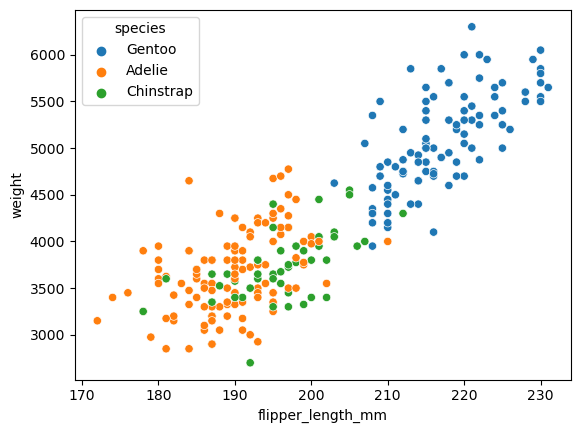

In [462]:
sns.scatterplot(
    data=x_train,
    x="flipper_length_mm",
    y="weight",
    hue="species",
    # size=0.1
)

<Axes: xlabel='species', ylabel='weight'>

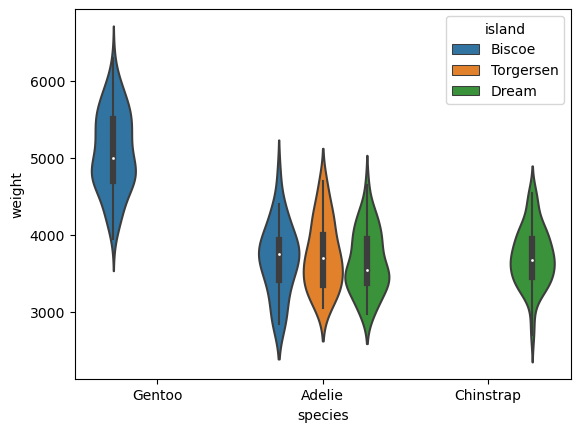

In [471]:
sns.violinplot(
    data=x_train,
    x="species",
    y="weight",
    hue="island"
)

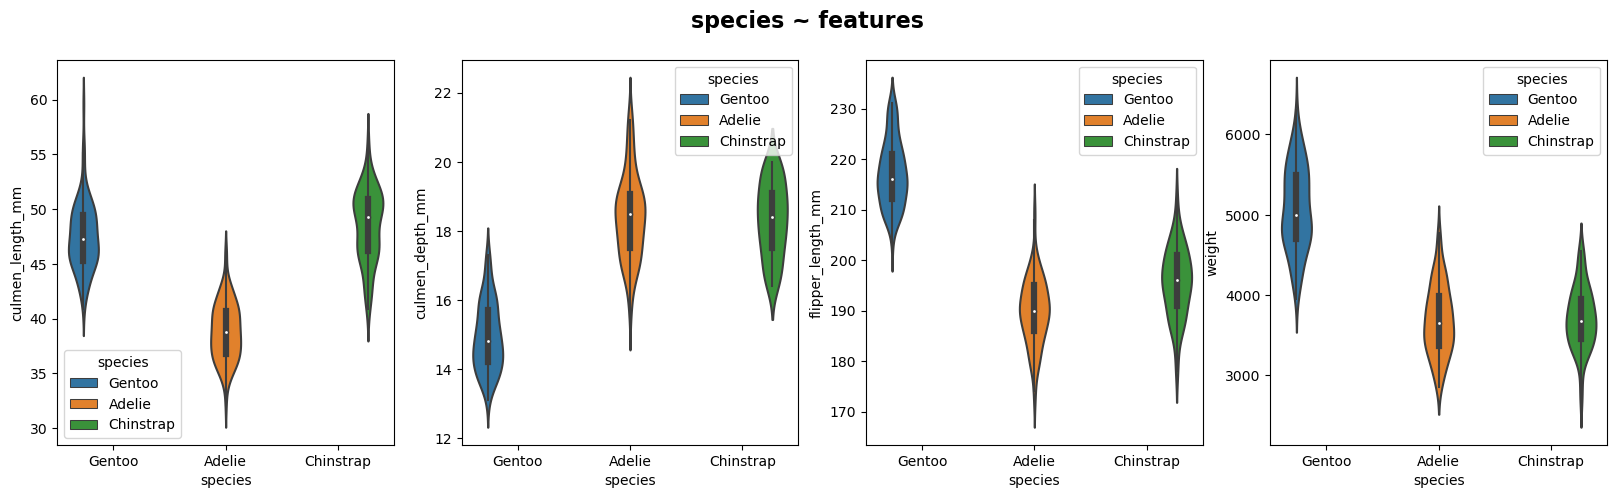

In [469]:
numerical_features = ["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", "weight"]
fig,ax = plt.subplots(1,len(numerical_features), figsize=(20,5))

for i, col in enumerate(numerical_features):
        sns.violinplot(
            ax=ax[i],
            data=x_train,
            x='species',
            y=col,
            hue='species',
            )
plt.suptitle('species ~ features', fontweight = 'heavy', fontsize = '16')
plt.show()

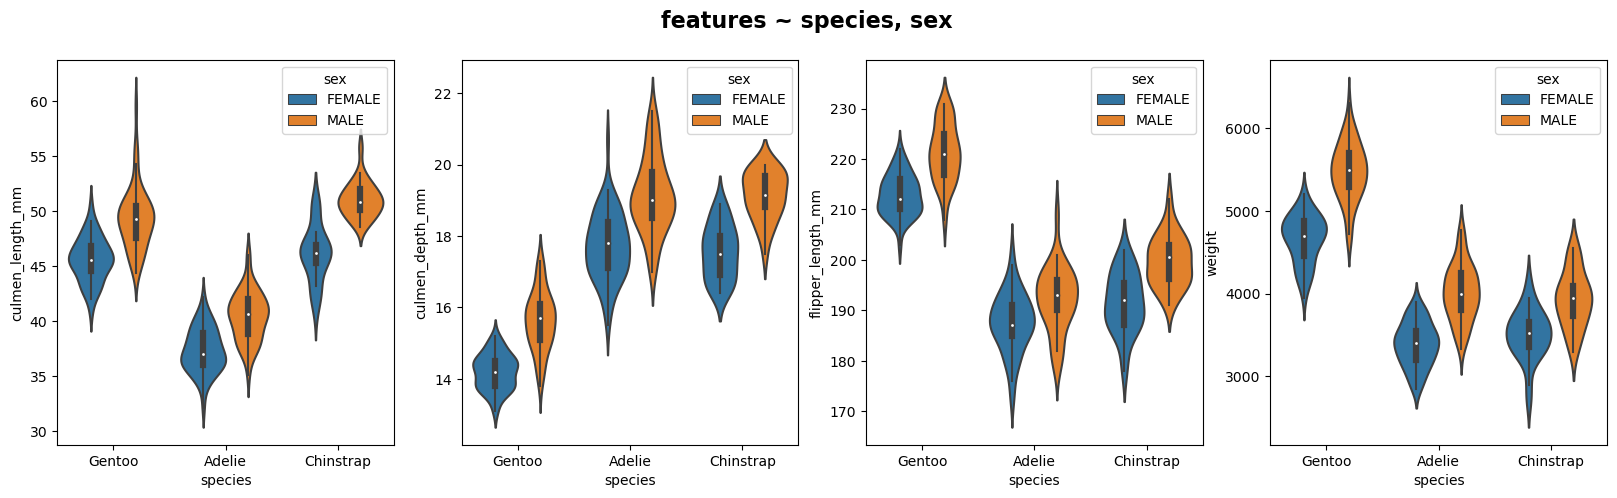

In [470]:
fig,ax = plt.subplots(1,len(numerical_features), figsize=(20,5))

for i, col in enumerate(numerical_features):
        sns.violinplot(
            # split=True,
            ax=ax[i],
            data=x_train,
            x='species',
            y=col,
            hue='sex',
            )
plt.suptitle('features ~ species, sex', fontweight = 'heavy', fontsize = '16')
plt.show()

<Axes: xlabel='flipper_length_mm', ylabel='Count'>

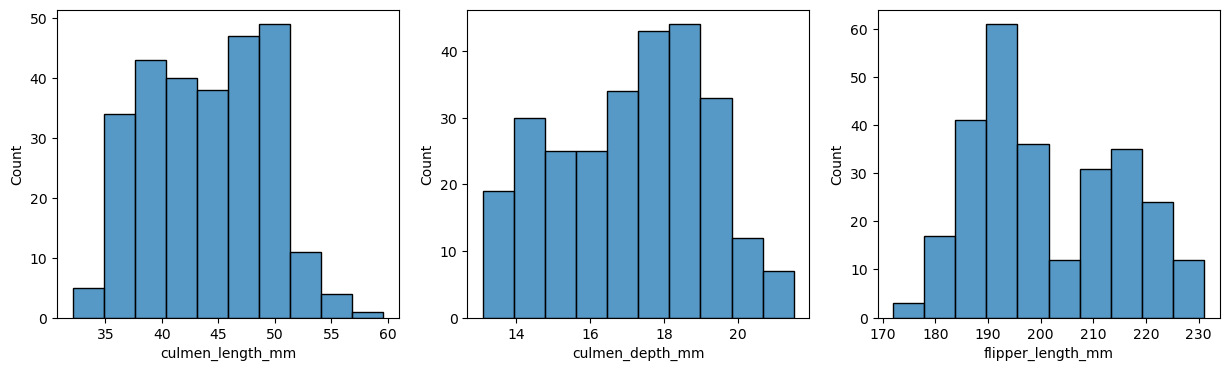

In [367]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

sns.histplot(
    data=x_train,
    x="culmen_length_mm",
    ax=axes[0]
)

sns.histplot(
    data=x_train,
    x="culmen_depth_mm",
    ax=axes[1]
)

sns.histplot(
    data=x_train,
    x="flipper_length_mm",
    ax=axes[2]
)

각 변수의(부리 길이, 높이, 날개 길이) 히스토그램을 그려봤다. 생각한 것과 다르게 꽤 완만하게 분포되어있는 것을 알 수 있다.

<Axes: >

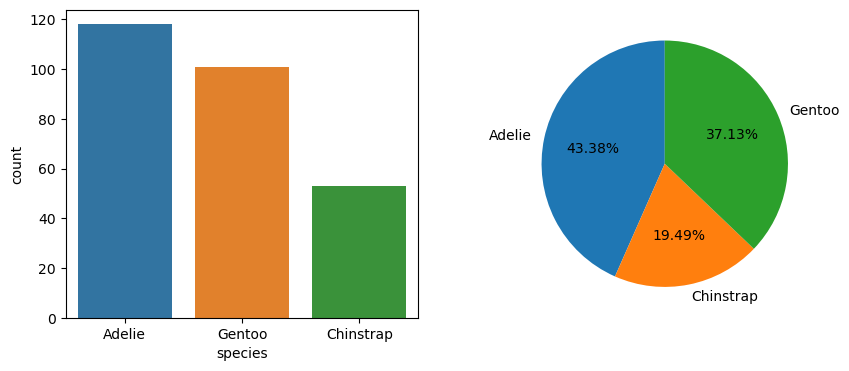

In [368]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

# Countplot
sns.countplot(
    data=x_train, 
    x='species',
    order= x_train['species'].value_counts().index,
    ax=axes[0],
)


# Pie Chart
x_train.groupby('species').size().plot(kind='pie', ax=axes[1], autopct='%.2f%%', startangle=90)

각 종들의 개체 수를 그래프로 나타내 보았다. 아델리는 43.38%, 젠투는 37.13%, 턱끈은 19.49%로 아델리펭귄의 개체 수가 가장 많았다.

<Axes: >

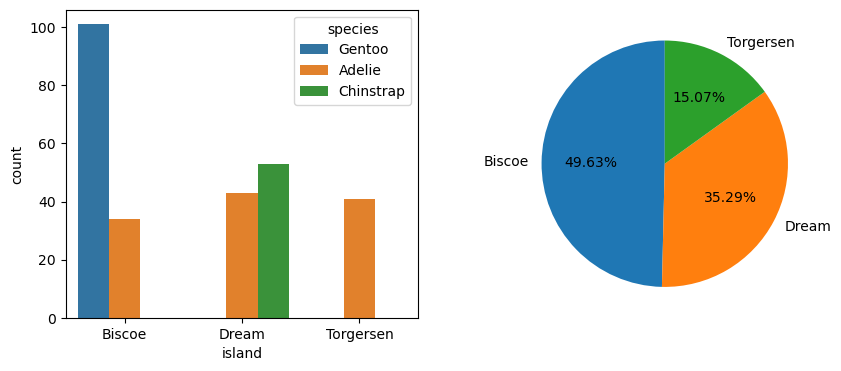

In [369]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

# Countplot
sns.countplot(
    data=x_train, 
    x="island",
    hue="species",
    order= x_train['island'].value_counts().index,
    ax=axes[0],
)


# Pie Chart
x_train.groupby('island').size().plot(kind='pie', ax=axes[1], autopct='%.2f%%', startangle=90)

서식지에 분포되어 있는 펭귄의 수를 그래프로 나타내 보았다. Biscoe 섬에 서식하는 펭귄이 압도적으로 많았고 Dream, Torgersen 섬이 차례로 이어졌다. 

왼쪽 bar그래프를 보면 어라?.? 아델리펭귄은 모든 섬에 서식하고 있는 것을 볼 수 있다. 이를 통해 
### 가설1. 서식지에 따라 몸무게에 변화가 있을 것이다(빠밤)
라는 가설을 세워보았다.

3개 집단을 비교해야하기 때문에 ANOVA 분석을 실시하였다.

- 귀무 가설: 모든 그룹의 평균이 같다.
- 대립 가설: 적어도 한 그룹의 평균은 다르다.

In [370]:
x_train

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,sex,weight
225,Gentoo,Biscoe,46.5,13.5,210.0,FEMALE,4550.0
119,Adelie,Torgersen,41.1,18.6,189.0,MALE,3325.0
181,Chinstrap,Dream,52.8,20.0,205.0,MALE,4550.0
167,Chinstrap,Dream,50.5,19.6,201.0,MALE,4050.0
226,Gentoo,Biscoe,45.4,14.6,211.0,FEMALE,4800.0
...,...,...,...,...,...,...,...
9,Adelie,Torgersen,42.0,20.2,190.0,MALE,4250.0
47,Adelie,Dream,37.5,18.9,179.0,FEMALE,2975.0
286,Gentoo,Biscoe,46.2,14.4,214.0,MALE,4650.0
246,Gentoo,Biscoe,44.5,14.3,216.0,FEMALE,4100.0


In [376]:
adelie_train = x_train[x_train["species"]=="Adelie"]
adelie_train

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,sex,weight
119,Adelie,Torgersen,41.1,18.6,189.0,MALE,3325.0
130,Adelie,Torgersen,38.5,17.9,190.0,FEMALE,3325.0
135,Adelie,Dream,41.1,17.5,190.0,MALE,3900.0
79,Adelie,Torgersen,42.1,19.1,195.0,MALE,4000.0
7,Adelie,Torgersen,39.2,19.6,195.0,MALE,4675.0
...,...,...,...,...,...,...,...
54,Adelie,Biscoe,34.5,18.1,187.0,FEMALE,2900.0
10,Adelie,Torgersen,37.8,17.1,186.0,FEMALE,3300.0
9,Adelie,Torgersen,42.0,20.2,190.0,MALE,4250.0
47,Adelie,Dream,37.5,18.9,179.0,FEMALE,2975.0


In [377]:
biscoe = adelie_train[adelie_train["island"]=="Biscoe"]
dream = adelie_train[adelie_train["island"]=="dream"]
torgersen = adelie_train[adelie_train["island"]=="torgersen"]

In [29]:
stat, pvalue = f_oneway(biscoe.loc[:, "weight"], dream.loc[:, "weight"], torgersen.loc[:, "weight"])
if pvalue < 0.05:
    print(f"p-value: {pvalue} -> 귀무가설 기각!")
else:
    print(f"p-value: {pvalue} -> 귀무가설 채택!")

p-value: 0.6759229573735942 -> 귀무가설 채택!


In [26]:
from scipy.stats import f_oneway

biscoe = x_train[(x_train['island']=='Biscoe')&(x_train['species']=='Adelie')]
dream = x_train[(x_train['island']=='Dream')&(x_train['species']=='Adelie')]
torgersen = x_train[(x_train['island']=='Torgersen')&(x_train['species']=='Adelie')]

for column in ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'weight']:
    stat, pvalue = f_oneway(biscoe.loc[:, column], dream.loc[:, column], torgersen.loc[:, column])
    if pvalue < 0.05:
        print(f"{column}의 p-value: {pvalue}\t\t -> 대립가설 기각!")
    else:
        print(f"{column}의 p-value: {pvalue}\t\t -> 귀무가설 채택!")

culmen_length_mm의 p-value: 0.45084166134543		 -> 귀무가설 채택!
culmen_depth_mm의 p-value: 0.7572923263819271		 -> 귀무가설 채택!
flipper_length_mm의 p-value: 0.2811521699013459		 -> 귀무가설 채택!
weight의 p-value: 0.6759229573735942		 -> 귀무가설 채택!


One_way ANOVA를 실시한 결과 유의확률이 유의수준 0.05보다 크기 때문에 귀무가설을 기각할 수 없다. 즉, Biscoe, Dream, Torgersen 섬에 서식하는 아델리펭귄의 몸무게 평균은 같다고 할 수 있다. 고로 서식지와 몸무게 간의 관계는 없다고 할 수 있을 것 같다.


그렇다면 몸무게에 영향을 미치는 변수는 무엇이 있을까? -> 히트맵을 그려보면 되겠다!

히트맵을 그리기 전, label encoding을 진행하였다. 현재 서식지를 제외하면 species와 sex가 범주형 변수로 되어있어서 sex는 label encoding으로, species는 one-hot encoding을 해주었다.

In [387]:
# sex -> label encoding
# >> 0: FEMALE, 1: MALE
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
x_train["sex"] = label_encoder.fit_transform(x_train["sex"])

In [388]:
x_train

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,sex,weight
225,Gentoo,Biscoe,46.5,13.5,210.0,0,4550.0
119,Adelie,Torgersen,41.1,18.6,189.0,1,3325.0
181,Chinstrap,Dream,52.8,20.0,205.0,1,4550.0
167,Chinstrap,Dream,50.5,19.6,201.0,1,4050.0
226,Gentoo,Biscoe,45.4,14.6,211.0,0,4800.0
...,...,...,...,...,...,...,...
9,Adelie,Torgersen,42.0,20.2,190.0,1,4250.0
47,Adelie,Dream,37.5,18.9,179.0,0,2975.0
286,Gentoo,Biscoe,46.2,14.4,214.0,1,4650.0
246,Gentoo,Biscoe,44.5,14.3,216.0,0,4100.0


In [389]:
# species -> one-hot encoding

dummies = pd.get_dummies(x_train, columns=["species"], prefix="species")
dummies = dummies.iloc[:, -3:]

In [390]:
dummies

,species_Adelie,species_Chinstrap,species_Gentoo
225,False,False,True
119,True,False,False
181,False,True,False
167,False,True,False
226,False,False,True
...,...,...,...
9,True,False,False
47,True,False,False
286,False,False,True
246,False,False,True


In [391]:
x_train = pd.concat([x_train, dummies], axis=1)

In [392]:
x_train = x_train.drop(["species"], axis=1)

In [393]:
x_train["species_Adelie"] = x_train["species_Adelie"].astype(int)
x_train["species_Chinstrap"] = x_train["species_Chinstrap"].astype(int)
x_train["species_Gentoo"] = x_train["species_Gentoo"].astype(int)

In [394]:
x_train

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,sex,weight,species_Adelie,species_Chinstrap,species_Gentoo
225,Biscoe,46.5,13.5,210.0,0,4550.0,0,0,1
119,Torgersen,41.1,18.6,189.0,1,3325.0,1,0,0
181,Dream,52.8,20.0,205.0,1,4550.0,0,1,0
167,Dream,50.5,19.6,201.0,1,4050.0,0,1,0
226,Biscoe,45.4,14.6,211.0,0,4800.0,0,0,1
...,...,...,...,...,...,...,...,...,...
9,Torgersen,42.0,20.2,190.0,1,4250.0,1,0,0
47,Dream,37.5,18.9,179.0,0,2975.0,1,0,0
286,Biscoe,46.2,14.4,214.0,1,4650.0,0,0,1
246,Biscoe,44.5,14.3,216.0,0,4100.0,0,0,1


ANOVA분석 결과에서 서식지와 몸무게는 별다른 연관성이 없다고 나왔기 때문에 제외하고 히트맵을 그렸다.

In [395]:
x_train_corr = x_train[["species_Adelie", "species_Chinstrap", "species_Gentoo", "culmen_length_mm",
                       "culmen_depth_mm", "flipper_length_mm", "sex", "weight"]]

<Axes: >

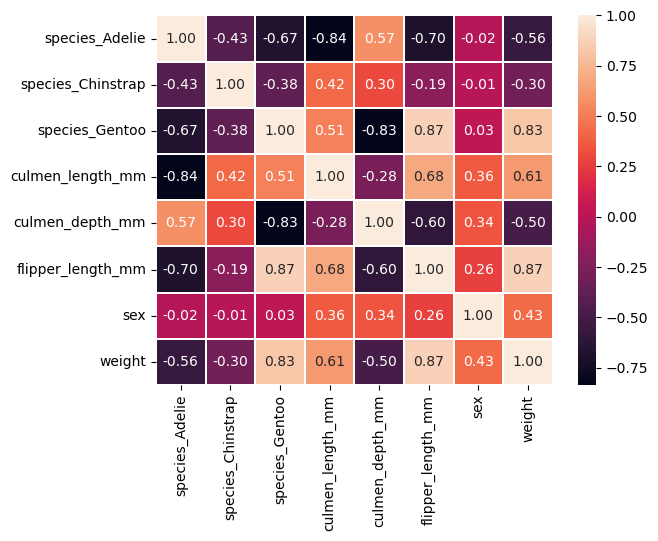

In [396]:
sns.heatmap(
    data=x_train_corr.corr(),
    annot=True,
    fmt=".2f",
    linewidth=0.1
)

펭귄의 몸무게와 연관이 있는 변수는 무엇이 있을까 해서 히트맵을 그려보았다. 그 결과 날개 길이와 젠투펭귄에서 강한 상관관계가 있는 것을 확인할 수 있었다. 
-> 다중 선형 회귀 모델을 학습시킬 때 2개는 기본으로 가져가야 되겠다~

In [427]:
x_train

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,sex,weight,species_Adelie,species_Chinstrap,species_Gentoo
225,Biscoe,46.5,13.5,210.0,0,4550.0,0,0,1
119,Torgersen,41.1,18.6,189.0,1,3325.0,1,0,0
181,Dream,52.8,20.0,205.0,1,4550.0,0,1,0
167,Dream,50.5,19.6,201.0,1,4050.0,0,1,0
226,Biscoe,45.4,14.6,211.0,0,4800.0,0,0,1
...,...,...,...,...,...,...,...,...,...
9,Torgersen,42.0,20.2,190.0,1,4250.0,1,0,0
47,Dream,37.5,18.9,179.0,0,2975.0,1,0,0
286,Biscoe,46.2,14.4,214.0,1,4650.0,0,0,1
246,Biscoe,44.5,14.3,216.0,0,4100.0,0,0,1


## 다중 선형 회귀

In [403]:
import statsmodels.api as sm

def train_multiple_linear_regression(X, y):
    X_constant = sm.add_constant(X, has_constant="add")
    model = sm.OLS(y, X_constant)
    results = model.fit()
    # return results
    print(results.summary())

In [404]:
y_train = x_train["weight"]

In [406]:
x_cur_train = x_train[["flipper_length_mm", "species_Gentoo", "sex", "culmen_depth_mm"]]
results = train_multiple_linear_regression(x_cur_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     436.9
Date:                Fri, 19 Jan 2024   Prob (F-statistic):          8.00e-116
Time:                        02:36:53   Log-Likelihood:                -1932.8
No. Observations:                 272   AIC:                             3876.
Df Residuals:                     267   BIC:                             3894.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -753.8400    630.42

In [268]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 weight   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     436.9
Date:                Fri, 19 Jan 2024   Prob (F-statistic):          8.00e-116
Time:                        00:47:13   Log-Likelihood:                -1932.8
No. Observations:                 272   AIC:                             3876.
Df Residuals:                     267   BIC:                             3894.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -753.8400    630.428     -1.196      0.233   -1995.082     487.402
flipper_length_mm    15.0528      3.064      4.913      0.000       9.021      21.085
species_Gentoo     1239.0410    125.404      9.880      0.000     992.135    1485.947
sex                 449.0911     50.128      8.959      0.000     350.394     547.788
culmen_depth_mm      73.4005     22.098      3.322      0.001      29.892     116.909
==============================================================================
Omnibus:                        0.069   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.966   Jarque-Bera (JB):                0.022
Skew:                           0.022   Prob(JB):                        0.989
Kurtosis:                       3.001   Cond. No.                     7.08e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 다중 공선성 확인

In [407]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

def check_multi_colinearity(X):
    vif = pd.DataFrame()
    vif["Features"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif.sort_values(by="VIF", ascending=False)

In [408]:
check_multi_colinearity(x_cur_train)

,Features,VIF
0,flipper_length_mm,434.049142
3,culmen_depth_mm,358.500449
1,species_Gentoo,17.079267
2,sex,2.489822


VIF 값을 확인했을 때 flipper_length와 culmen_depth의 값이 10보다 너~무 크게 나왔다. 이는 해당 독립 변수가 다른 독립 변수에 의존하고 있다는 의미이므로 일단 가장 높은 VIF값인 flipper_length를 제거한 후 다시 확인해보았다.

In [409]:
x_cur_train = x_cur_train.drop(["flipper_length_mm"], axis=1)

In [410]:
check_multi_colinearity(x_cur_train)

,Features,VIF
2,culmen_depth_mm,2.392036
1,sex,2.149875
0,species_Gentoo,1.403052


flipper_length를 제거한 후 VIF 값을 다시 확인해보니 나머지 변수들 모두 10이하로 나왔다. flipper_length를 제거한 데이터로 다시 다중 선형 회귀 모델을 돌렸을 때 결과는 다음과 같았다.

In [411]:
results = train_multiple_linear_regression(x_cur_train, y_train)
# results.summary()

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     528.8
Date:                Fri, 19 Jan 2024   Prob (F-statistic):          3.30e-112
Time:                        02:37:20   Log-Likelihood:                -1944.6
No. Observations:                 272   AIC:                             3897.
Df Residuals:                     268   BIC:                             3912.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1703.1343    400.148     

변수가 4개였을 때 R2(0.867) 보다 조금 낮은 0.855로 꽤 나쁘지 않은 성능이라고 할 수 있겠다. 그리고 f스코어의 유의확률을 확인했을 때에도 유의확률이 매우 작아서 괜찮은 모델이라고 판단할 수 있겠다.

2번째 표) 각 변수들의 유의확률이 0.00으로 매우 유의한 값이므로 제거할 변수는 없었다.

3번째 표) skewness의 절대값이 2보다 작으므로 정규분포에서 크게 벗어나지 않는다고 할 수 있겠다. 또한 kurtosis의 절대값이 7보다 작기 때문에 정규성을 벗어나지 않는다고 할 수 있다.

-> R2 값 높고, 각 변수들의 유의확률 모두 유의하고, 마지막으로 정규성을 벗어나지 않았기 때문에 꽤 괜찮은 모델이다~ (좋은 성능을 기대한다면 미안하지만 다른 모델로 가시길...)

## Lasso 모델(L1)

In [413]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x_test도 label, one-hot encoding 실시

In [414]:
x_test["weight"] = y_test

In [415]:
x_test

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,sex,weight
65,Adelie,Biscoe,41.6,18.0,192.0,MALE,3950.0
311,Gentoo,Biscoe,52.2,17.1,228.0,MALE,5400.0
264,Gentoo,Biscoe,50.5,15.9,222.0,MALE,5550.0
98,Adelie,Dream,33.1,16.1,178.0,FEMALE,2900.0
38,Adelie,Dream,37.6,19.3,181.0,FEMALE,3300.0
...,...,...,...,...,...,...,...
343,Gentoo,Biscoe,49.9,16.1,213.0,MALE,5400.0
327,Gentoo,Biscoe,53.4,15.8,219.0,MALE,5500.0
296,Gentoo,Biscoe,47.5,14.2,209.0,FEMALE,4600.0
41,Adelie,Dream,40.8,18.4,195.0,MALE,3900.0


In [416]:
x_test = x_test.dropna()

In [417]:
# sex -> label encoding
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
x_test["sex"] = label_encoder.fit_transform(x_test["sex"])

/var/folders/bc/bsqk8v9x20jgf1jsh_fbh7z40000gn/T/ipykernel_22876/4016634740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test["sex"] = label_encoder.fit_transform(x_test["sex"])


In [418]:
# species -> one-hot encoding
dummies = pd.get_dummies(x_test, columns=["species"], prefix="species")
dummies = dummies.iloc[:, -3:]

In [419]:
x_test

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,sex,weight
65,Adelie,Biscoe,41.6,18.0,192.0,1,3950.0
311,Gentoo,Biscoe,52.2,17.1,228.0,1,5400.0
264,Gentoo,Biscoe,50.5,15.9,222.0,1,5550.0
98,Adelie,Dream,33.1,16.1,178.0,0,2900.0
38,Adelie,Dream,37.6,19.3,181.0,0,3300.0
...,...,...,...,...,...,...,...
343,Gentoo,Biscoe,49.9,16.1,213.0,1,5400.0
327,Gentoo,Biscoe,53.4,15.8,219.0,1,5500.0
296,Gentoo,Biscoe,47.5,14.2,209.0,0,4600.0
41,Adelie,Dream,40.8,18.4,195.0,1,3900.0


In [420]:
x_test = pd.concat([x_test, dummies], axis=1)

In [421]:
x_test = x_test.drop(["species"], axis=1)

In [422]:
x_test["species_Adelie"] = x_test["species_Adelie"].astype(int)
x_test["species_Chinstrap"] = x_test["species_Chinstrap"].astype(int)
x_test["species_Gentoo"] = x_test["species_Gentoo"].astype(int)

x_test 데이터도 x_train에 맞게 전처리를 해 주었다.

In [423]:
columns = ["species_Gentoo", "sex", "culmen_depth_mm"]
x_cur_train = x_train[columns]
x_cur_test = x_test[columns]

In [424]:
y_train = x_train["weight"]
y_test = x_test["weight"]

In [425]:
import numpy as np

model = Lasso()
model.fit(x_cur_train, y_train)
y_pred = model.predict(x_cur_test)
print("R2 score", r2_score(y_test, y_pred))
print("MSE", np.sqrt(mean_squared_error(y_test, y_pred)))
print("sum of abs coefficient", np.abs(model.coef_).sum())

R2 score 0.8394142774495268
MSE 305.6054889861129
sum of abs coefficient 2288.210797506624


## Ridge 모델(L2)

In [426]:
import numpy as np

model = Ridge()
model.fit(x_cur_train, y_train)
y_pred = model.predict(x_cur_test)
print("R2 score", r2_score(y_test, y_pred))
print("MSE", np.sqrt(mean_squared_error(y_test, y_pred)))
print("sum of abs coefficient", np.abs(model.coef_).sum())

R2 score 0.8368497024312465
MSE 308.0361029581894
sum of abs coefficient 2201.3302141438476


## 총정리

In [341]:
import numpy as np

model = LinearRegression()
model.fit(x_cur_train, y_train)
y_pred = model.predict(x_cur_test)
print("다중 선형 회귀 모델 결과")
print("R2 score", r2_score(y_test, y_pred))
print("MSE", np.sqrt(mean_squared_error(y_test, y_pred)))
print("sum of abs coefficient", np.abs(model.coef_).sum())
print("----------------------------------------------------")

model = Lasso()    # alpha값은 수식에서의 람다 값을 의미
model.fit(x_cur_train, y_train)
y_pred = model.predict(x_cur_test)
print("Lasso 모델 결과")
print("R2 score", r2_score(y_test, y_pred))
print("MSE", np.sqrt(mean_squared_error(y_test, y_pred)))
print("sum of abs coefficient", np.abs(model.coef_).sum())
print("----------------------------------------------------")

model = Ridge()
model.fit(x_cur_train, y_train)
y_pred = model.predict(x_cur_test)
print("Ridge 모델 결과")
print("R2 score", r2_score(y_test, y_pred))
print("MSE", np.sqrt(mean_squared_error(y_test, y_pred)))
print("sum of abs coefficient", np.abs(model.coef_).sum())

다중 선형 회귀 모델 결과
R2 score 0.8398280281072246
MSE 305.2115373274696
sum of abs coefficient 2310.023620805939
----------------------------------------------------
Lasso 모델 결과
R2 score 0.8394142774495268
MSE 305.6054889861129
sum of abs coefficient 2288.210797506624
----------------------------------------------------
Ridge 모델 결과
R2 score 0.8368497024312465
MSE 308.0361029581894
sum of abs coefficient 2201.3302141438476
